In [ ]:
# I used this article as a guide for hyperparameter tuning
# http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from xgboost import XGBClassifier
from xgboost import plot_importance

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV

from catboost import CatBoostClassifier
import lightgbm as lgb


# Data Exploration & Basic Preprocessing

In [ ]:
# get the data
train_data = pd.read_csv("train_final.csv")
test_data = pd.read_csv("test_final.csv")

In [ ]:
# detect any missing values on train
missing_values = train_data.isnull().sum()
print(missing_values)

In [ ]:
# detect any missing values on test
missing_values = test_data.isnull().sum()
print(missing_values)

No missing values detected

In [ ]:
train_data.describe()

In [ ]:
test_data.describe()

In [ ]:
# create a copy of train data for any preprocessing
X_train = train_data.copy()
X_train.head(5)

In [ ]:
# create a copy of train data for any preprocessing
X_test = test_data.copy()
X_test.head(5)

In [ ]:
# Preprocessing:

# separate features and y for train data
y_train = X_train[["Y"]]
del X_train["Y"]

# Id not a feature, does not decide Y -> delete for train
del X_train["Id"]

X_train.head(5)

In [ ]:
y_train.head(5)

In [ ]:
# Id not a feature, does not decide Y -> delete for test
del X_test["Id"]

X_test.head(5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ddf9b80>,
      dtype=object)

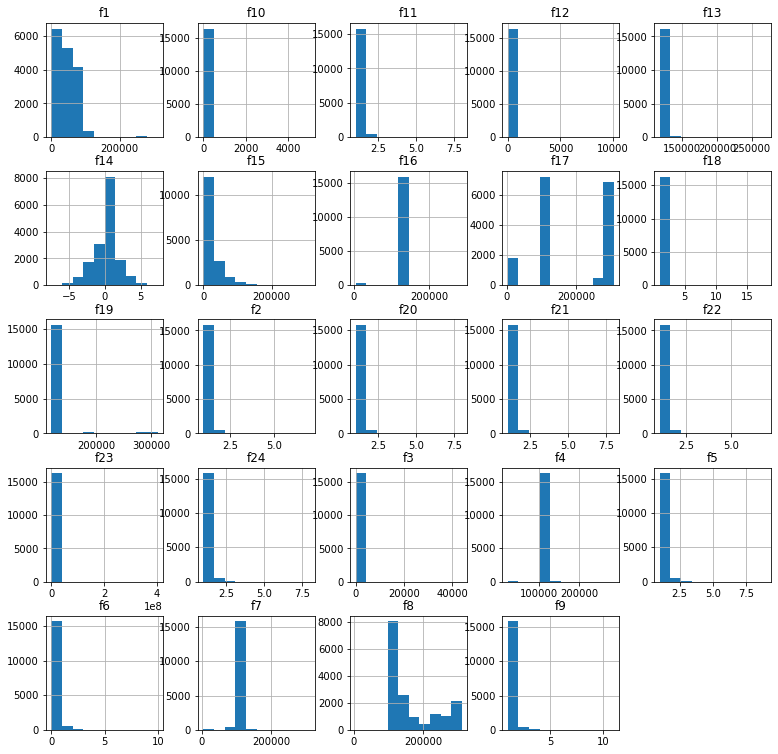

In [140]:
# Distribution of all the variables in data set
X_train.hist(figsize=[13,13])

EDA conclusions:

No missing values

Many features are categorical. Since the categorical features have a lot of unique values, will not use one hot encoding. Use cat_features

Categorical features: 2,3,4,5,6,7,9,11,12,13,16,17,18,19,20,21,22,23,24

Not categorical: 1,8,14,15

# In-depth preprocessing

In [149]:
# https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview 

# Categorical features: 2,3,4,5,6,7,9,11,12,13,16,17,18,19,20,21,22,23,24
# Not categorical: 1,8,14,15

# Get list of catergorical columns
cat_features_names = [col for col in X_train.columns if not 
                      (col == "f1" or col == "f8" or col == "f14" or col == "f15")]

cat_features = [X_train.columns.get_loc(col) for col in cat_features_names]

# Preprocessing for catboost
# Make all categorical features type int for catboost
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
for col in cat_features_names:
    X_train_cat[col] = X_train_cat[col].astype(np.int)
    X_test_cat[col] = X_test_cat[col].astype(np.int)
    
    
# Preprocessing for XGB
# Encode categorical features

# X train
df = pd.get_dummies(X_train, columns=cat_features_names)

# X test
X_test_dummy = pd.get_dummies(X_test, columns=cat_features_names)
df

,f1,f8,f14,f15,f2_1,f2_2,f2_3,f2_4,f2_5,f2_6,...,f23_17681416,f23_42640756,f23_404288627,f24_1,f24_2,f24_3,f24_4,f24_5,f24_6,f24_8
0,25884,125738,-2.266430,1945,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,34346,130913,-0.305612,15385,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,34923,124402,2.015561,7547,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,80926,301218,-3.172501,4933,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4674,302830,0.573767,13836,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16378,33328,117906,1.000000,4533,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16379,19944,132097,1.000000,4663,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16380,28359,174445,1.806069,7822,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16381,7542,117906,-1.245079,6257,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


"In a decision tree (and various ensembles thereof), keeping all the dummies is beneficial: if you remove the first dummy, then the model can only select on that level by selecting (through several steps in the tree, rather unlikely!) "not this other dummy."
Then again, it's probably better not to one-hot encode at all for decision trees, but for now some packages don't deal innately with categorical variables."

https://datascience.stackexchange.com/questions/47638/in-which-cases-shouldnt-we-drop-the-first-level-of-categorical-variables

# XGB parameter tuning (without dummified X_train)

In [ ]:
# First tune the highest impact parameters
# Typical initial estimators for everything else

param_test1 = {
    'max_depth':range(3,11,2),
    'min_child_weight':range(1,7,2)
}


gsearch1 = GridSearchCV(
            estimator = XGBClassifier(
                            learning_rate = 0.1, 
                            n_estimators = 140, 
                            gamma = 0, 
                            subsample = 0.8, 
                            colsample_bytree = 0.8,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test1, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearch1.fit(X_train,y_train.values.ravel())

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.8730321403335572)

In [ ]:
# Search for 1 above and below opt parameters 1 because previous values were searched in intervals of 2

param_test2 = {
    'max_depth':[8,9,10],
    'min_child_weight':[0,1,2]
}

gsearch2 = GridSearchCV(
            estimator = XGBClassifier(
                            learning_rate = 0.1, 
                            n_estimators = 140, 
                            gamma = 0, 
                            subsample = 0.8, 
                            colsample_bytree = 0.8,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test2, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearch2.fit(X_train,y_train.values.ravel())

In [ ]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 10, 'min_child_weight': 2}, 0.8741829477411631)

In [ ]:
# Search for gamma with optimized max_depth and min_child_weight

param_test3 = {
     'gamma':[0,0.1,0.2,0.3,0.4,0.5]
}

gsearch3 = GridSearchCV(
            estimator = XGBClassifier(
                            max_depth = 10,
                            min_child_weight = 2,
                            learning_rate = 0.1, 
                            n_estimators = 140, 
                            # gamma = 0, 
                            subsample = 0.8, 
                            colsample_bytree = 0.8,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test3, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearch3.fit(X_train,y_train.values.ravel())

In [ ]:
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# search for reg_alpha -> to reduce overfitting

param_test4 = {
     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch4 = GridSearchCV(
            estimator = XGBClassifier(
                            max_depth = 10,
                            min_child_weight = 2,
                            learning_rate = 0.1, 
                            n_estimators = 140, 
                            gamma = 0.1, 
                            subsample = 0.8, 
                            colsample_bytree = 0.8,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test4, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearch4.fit(X_train,y_train.values.ravel())

In [ ]:
gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# Search OPT subsample, colsample_bytree
# Reduce learning rate, increase trees

param_test5 = {
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

gsearch5 = GridSearchCV(
            estimator = XGBClassifier(
                            max_depth = 10,
                            min_child_weight = 2,
                            learning_rate = 0.01, 
                            n_estimators = 1000, 
                            gamma = 0.1, 
                            #subsample = 0.8, 
                            #colsample_bytree = 0.8,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test5, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearch5.fit(X_train,y_train.values.ravel())

In [ ]:
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.8}, 0.8831224337343377)

In [106]:
# Creating a model using optimal parameters

XGBparams = {
    'max_depth': 10,
    'min_child_weight': 2,
    'learning_rate': 0.01, 
    'n_estimators': 1000, 
    'gamma': 0.1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.5,
    'objective':'binary:logistic',  
    'scale_pos_weight': 1, 
    'seed': 42
}

xgb_model = XGBClassifier(**XGBparams)

xgb_model.fit(X_train,y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [107]:
cross_val_score(xgb_model, X_train, y_train.values.ravel(), 
                cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True),
                scoring="roc_auc")

array([0.87680937, 0.89609568, 0.8870646 , 0.87903874, 0.87899246])

with shuffle: array([0.87680937, 0.89609568, 0.8870646 , 0.87903874, 0.87899246])


when an integer number is passed to GridSearchCV(..., cv=int_number) parameter, then the StratifiedKFold will be used for cross-validation splitting. So the data set will be randomly splitted by StratifiedKFold. This might affect the accuracy and therefore the best score.

In [ ]:
y_PredictProbXGB = xgb_model.predict_proba(X_test)
ypredXGB = y_PredictProbXGB[:,1]

In [147]:
# Find optimal features 
# https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization#Feature-Selection-and-Random-Forest-Classification

# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=xgb_model, step=1, cv=5, scoring='accuracy', n_jobs=-1)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train.values.ravel())

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])
print("Accuracy: ", rfecv.score(X_train, y_train))
os.system("say 'bingo'")

X_opt = rfecv.transform(X_train)
X_opt_df = pd.DataFrame(X_opt)   

xgb_OPT_model = XGBClassifier(**XGBparams)
xgb_OPT_model.fit(X_opt_df,y_train.values.ravel())
cross_val_score(xgb_OPT_model, X_train, y_train.values.ravel(), 
                cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True),
                scoring="roc_auc")

Optimal number of features : 9
Best features : Index(['f1', 'f4', 'f7', 'f8', 'f14', 'f15', 'f16', 'f17', 'f19'], dtype='object')
Accuracy:  0.9775376915094915


array([0.89011474, 0.87962849, 0.87647009, 0.87715424, 0.88196448])

Optimal number of features : 9
Best features : Index(['f1', 'f4', 'f7', 'f8', 'f14', 'f15', 'f16', 'f17', 'f19'], dtype='object')

Accuracy:  0.9775376915094915

Using this as a model sucked - DO NOT USE

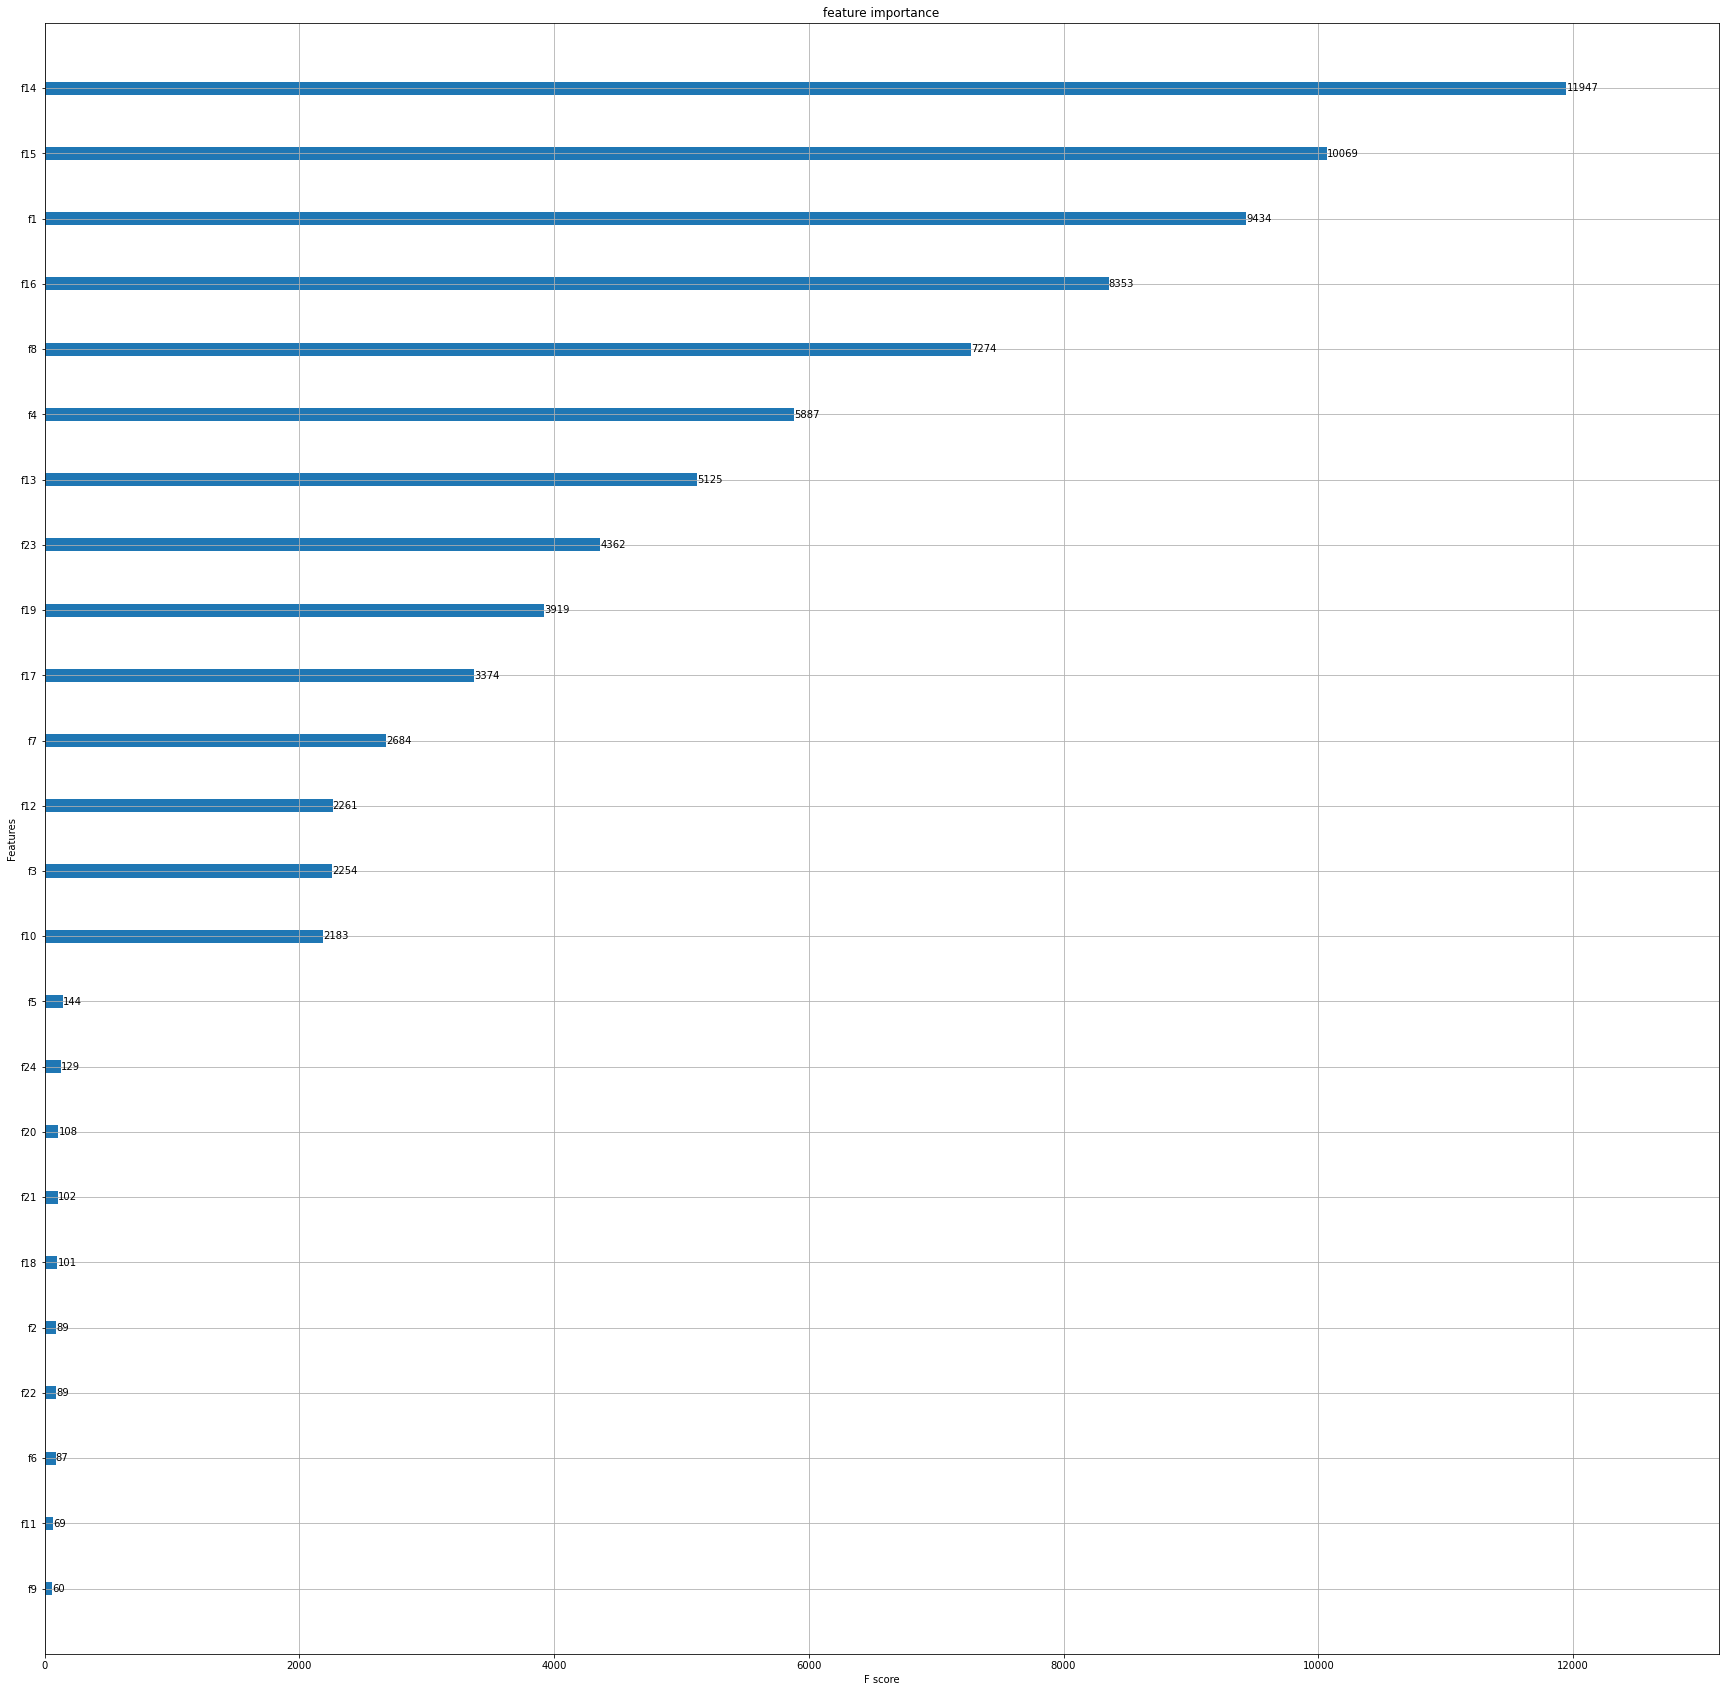

In [145]:
plot_importance(xgb_model)
plt.title("feature importance")
plt.rcParams["figure.figsize"] = (25,30)
plt.show()

# XGB with dummy X_train

Used OPT paramters found with X_train normal to save time

In [95]:
# Using dummy X_train (preprocessed)

param_test_xgb = {}

gsearchXGB = GridSearchCV(
            estimator = XGBClassifier(
                            max_depth = 10,
                            min_child_weight = 2,
                            learning_rate = 0.01, 
                            n_estimators = 1000, 
                            gamma = 0.1, 
                            subsample = 0.8, 
                            colsample_bytree = 0.5,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test_xgb, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearchXGB.fit(df,y_train.values.ravel())
gsearchXGB.best_params_, gsearchXGB.best_score_

({}, 0.8671792256439248)

({}, 0.8671792256439248)

Clearly much worse for some reason. I don't know why. Gonna try to run grid search incase parameters need to be tuned again

In [ ]:
# Using dummy X_train (preprocessed)

param_test_xgb = {
    'max_depth':range(3,11,2),
    'min_child_weight':range(1,7,2)
}

gsearchXGB = GridSearchCV(
            estimator = XGBClassifier(
                            #max_depth = 10,
                            #min_child_weight = 2,
                            learning_rate = 0.01, 
                            n_estimators = 100, 
                            gamma = 0.1, 
                            subsample = 0.8, 
                            colsample_bytree = 0.5,
                            objective = 'binary:logistic',  
                            scale_pos_weight = 1, 
                            seed=42), 
            param_grid = param_test_xgb, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=5)

gsearchXGB.fit(df,y_train.values.ravel())
gsearchXGB.best_params_, gsearchXGB.best_score_

({'max_depth': 9, 'min_child_weight': 3}, 0.8393735418342855)

OPT parameters approach original parameter values -> parameters not the issue

In [96]:
# Creating a model using optimal parameters DUMMY

XGBparams = {
    'max_depth': 10,
    'min_child_weight': 2,
    'learning_rate': 0.01, 
    'n_estimators': 1000, 
    'gamma': 0.1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.5,
    'objective':'binary:logistic',  
    'scale_pos_weight': 1, 
    'seed': 42
}

xgb_model_dummy = XGBClassifier(**XGBparams)
xgb_model_dummy.fit(df,y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [99]:
y_probXGB_dummy = xgb_model_dummy.predict_proba(X_test_dummy)
y_predXGB_dummy = y_probXGB_dummy[:,1]

# Random Forests Classifier

In [ ]:
# RandomForests Classifier
# In this search pattern, random combinations of parameters are considered in every iteration
# as regular grid search would run every combination and take too long

rfc_grid_param = {
    'n_estimators': [500, 1000, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 30, 40],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [2,5,10]
}

In [ ]:
# This took forever to run

RFC = RandomForestClassifier(random_state = 42)
gsearchRF = RandomizedSearchCV(estimator = RFC, 
                               param_distributions = rfc_grid_param,
                               n_iter = 500,
                               cv = 5,
                               verbose = 2,
                               random_state = 42,
                               scoring='roc_auc',
                               n_jobs = -1
                              )

gsearchRF.fit(X_train,y_train.values.ravel())

In [ ]:
gsearchRF.best_params_, gsearchRF.best_score_

({'n_estimators': 1500,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_features': 'auto',
  'max_depth': 30},
 0.8680228357670261)

In [108]:
# Creating a model using optimal parameters

RfcParams = {
    'n_estimators': 1500, 
    'min_samples_split': 5, 
    'min_samples_leaf': 2, 
    'max_features': 'auto', 
    'max_depth': 30
}

rfc_model = RandomForestClassifier(**RfcParams, random_state = 42)

rfc_model.fit(X_train,y_train.values.ravel())

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1500, random_state=42)

In [148]:
cross_val_score(rfc_model, X_train, y_train.values.ravel(), 
                cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True),
                scoring="roc_auc")

array([0.86394387, 0.85623412, 0.85799362, 0.87932669, 0.85759534])

# Catboost Parameter Tuning

In [ ]:
# Catboost
# Start with a relative high learning_rate
# Tune other parameters
# Decrease the learning_rate while increasing n_estimators

cat_param_test1 = {
    'depth':range(1,10,2),
    'min_data_in_leaf': range(1,10,2)
}


cat_gsearch1 = GridSearchCV(
            estimator = CatBoostClassifier(
                            learning_rate = 0.1, 
                            iterations = 200,
                            loss_function = 'Logloss', # try crossEntropy later
                            border_count = 32,
                            eval_metric="AUC",
                            random_seed=42), 
            param_grid = cat_param_test1, 
            scoring='roc_auc',
            n_jobs=-1,
            # use shuffle to verity validity of hyperparameters 
            cv= sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
            )

cat_gsearch1.fit(X_train,y_train.values.ravel())

In [ ]:
cat_gsearch1.best_params_, cat_gsearch1.best_score_

cv = 5: ({'depth': 7, 'min_data_in_leaf': 1}, 0.8560175950079281)

cv = 10: ({'depth': 7, 'min_data_in_leaf': 1}, 0.8633634575626921)

Shuffle = True -> provides a better metric for seeing how good model is

In [ ]:
# Tune depth
# Find best loss_function
# Steadily increase iterations

cat_param_test2 = {
    'depth': [6,7,8],
    'loss_function': ['Logloss', 'CrossEntropy']
}

cat_gsearch2 = GridSearchCV(
            estimator = CatBoostClassifier(
                            learning_rate = 0.1, 
                            iterations = 300,
                            #loss_function = 
                            border_count = 32,
                            eval_metric="AUC",
                            min_data_in_leaf = 1,
                            random_seed=42), 
            param_grid = cat_param_test2, 
            scoring='roc_auc',
            n_jobs=-1,
            # use shuffle to verity validity of hyperparameters 
            cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
)

cat_gsearch2.fit(X_train,y_train.values.ravel())

In [ ]:
cat_gsearch2.best_params_, cat_gsearch2.best_score_

({'depth': 6, 'loss_function': 'Logloss'}, 0.8624760944942352)

In [ ]:
# Add in cat_features

cat_param_test3 = {}

cat_gsearch3 = GridSearchCV(
            estimator = CatBoostClassifier(
                            learning_rate = 0.1, 
                            depth = 6,
                            iterations = 300,
                            loss_function = 'Logloss',
                            border_count = 32,
                            eval_metric="AUC",
                            min_data_in_leaf = 1,
                            cat_features = cat_features,
                            random_seed=42), 
            param_grid = cat_param_test3, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True))

cat_gsearch3.fit(X_train_cat,y_train.values.ravel())

In [ ]:
cat_gsearch3.best_params_, cat_gsearch3.best_score_

({}, 0.8965760909129535) -> incredible jump in score using cat_features

In [ ]:
# Decrease learning rate
# Increase iterations

cat_param_test4 = {
    'iterations' : [300, 500, 800]
}

cat_gsearch4 = GridSearchCV(
            estimator = CatBoostClassifier(
                            learning_rate = 0.01, 
                            depth = 6,
                            #iterations = 300,
                            loss_function = 'Logloss',
                            border_count = 32,
                            eval_metric="AUC",
                            min_data_in_leaf = 1,
                            cat_features = cat_features,
                            random_seed=42), 
            param_grid = cat_param_test4, 
            scoring='roc_auc',
            n_jobs=-1,
            cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True))

cat_gsearch4.fit(X_train_cat,y_train.values.ravel())

In [ ]:
cat_gsearch4.best_params_, cat_gsearch4.best_score_

In [109]:
# Creating a catboost model using optimal parameters

CATparams = {
    'learning_rate' : 0.01, 
    'depth' : 6,
    'iterations' : 800,
    'loss_function' : 'Logloss',
    'border_count' : 32,
    'eval_metric' : "AUC",
    'min_data_in_leaf' : 1,
    'cat_features' : cat_features,
    'random_seed' : 42,
    'silent' : True
}

cat_model = CatBoostClassifier(**CATparams)
cat_model.fit(X_train_cat,y_train.values.ravel())

In [110]:
cross_val_score(cat_model, X_train_cat, y_train.values.ravel(), 
                cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True),
                scoring="roc_auc")

array([0.89078649, 0.90327178, 0.89123319, 0.90565488, 0.89036633])

array([0.89078649, 0.90327178, 0.89123319, 0.90565488, 0.89036633])

In [ ]:
y_probCat = cat_model.predict_proba(X_test_cat)
y_predCat = y_probCat[:,1]

# Stacking

In [ ]:
# Stacked model using XGB (without dummy X) as final estimator

# Score: .90360 

estimators = [('rf', rfc_model),
              ('xgb', xgb_model),
              ('cat', cat_model)
             ]

bigXGB_stacker = StackingClassifier(n_jobs = -1, 
                                 estimators = estimators,
                                 
                                 final_estimator = xgb_model)

bigXGB_stacker.fit(X_train_cat, y_train.values.ravel() )

In [114]:
y_probFinal = bigXGB_stacker.predict_proba(X_test)

In [116]:
y_predFinal = y_probFinal[:,1]

In [112]:
# Stacked model using XGB (without dummy X) as final estimator

# Score: 

estimators = [#('rf', rfc_model),
              ('xgb', xgb_model),
              #('cat', cat_model)
             ]

bigXGB_stacker = StackingClassifier(n_jobs = -1, 
                                 estimators = estimators,
                                 final_estimator = xgb_model)

bigXGB_stacker.fit(X_train, y_train.values.ravel() )

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.5, gamma=0.1,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.01,
                                              max_delta_step=0, max_depth=10,
                                              min_child_weight=2, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=1000, n_jobs=0,
                                              num...
                                                 importance_type='gain',
                 

# Create Output dataframe

In [117]:
Id = test_data['Id']
finalOut = pd.DataFrame(Id)
finalOut.insert(1, "Y", y_predFinal)
finalOut.reset_index(drop=True, inplace=True)

In [118]:
finalOut

,Id,Y
0,16384,0.758324
1,16385,0.825408
2,16386,0.999717
3,16387,0.999717
4,16388,0.988046
...,...,...
16380,32764,0.999717
16381,32765,0.979579
16382,32766,0.999717
16383,32767,0.943897


In [119]:
finalOut.to_csv("finalOut.csv", index=False)

# FINAL SCORES #

### XGB (raw train) -> public: 0.90239, private: 0.89914

### XGB (dummy train) -> public: 0.81894, private: 0.80905

### RandomForests -> public: 0.88111, private: 0.88475

### Catboost -> public: 0.91667, private: 0.90152

### Stacking-xgb w/ rfc (raw train) -> public: 0.90360, private: 0.89688

### Stakcing-xgb w/ xgb -> public:0.87941, private: 0.88489

In [ ]:
# end